## Reading XDF EEG data

[{'channel_count': 1,
  'channel_format': 'int32',
  'created_at': '14012.78136030000',
  'hostname': 'LAPTOP-J323FJ6E',
  'name': 'psychopy_marker_stream',
  'nominal_srate': 0.0,
  'session_id': 'default',
  'source_id': 'myuniqueid1234',
  'stream_id': 1,
  'type': 'Markers',
  'uid': 'a9d0800b-cc52-41b1-b7a1-21e95f24d1ef'},
 {'channel_count': 8,
  'channel_format': 'float32',
  'created_at': '13914.5841351',
  'hostname': 'LAPTOP-J323FJ6E',
  'name': 'obci_eeg1',
  'nominal_srate': 250.0,
  'session_id': 'default',
  'source_id': 'openbcigui',
  'stream_id': 2,
  'type': 'EEG',
  'uid': '45b7f461-3a3d-47d9-a2b1-a77233ccd991'}]
Creating RawArray with float64 data, n_channels=8, n_times=22880
    Range : 0 ... 22879 =      0.000 ...    91.516 secs
Ready.


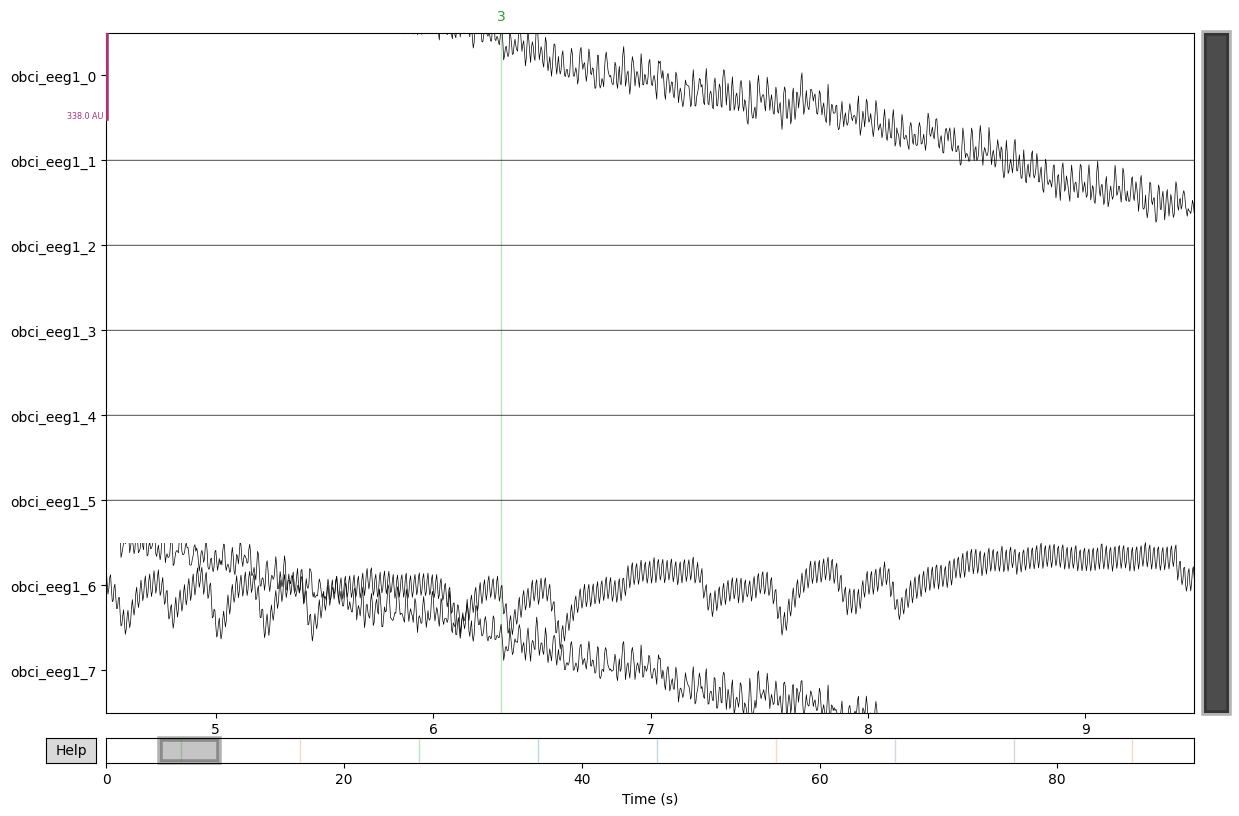

In [4]:
from readXDF import read_xdf

raw = read_xdf("test01_OpenBCI.xdf", show_plot=True) # For Interact-UI, recommended run in .py file.